In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold,\
                                    GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Problem Statement

This project aims to create an automated model that can differentiate conspiracy theories from factual posts and describe those differences based on grammar in order to maintain public image and prevent user exodus for smaller social media sites. Using a machine learning model to flag posts that are likely conspiracy has a huge cost advantage over paying people to monitor all posts manually.

In [2]:
df = pd.read_csv('../Data/master_df.csv')

In [3]:
1 - df['is_conspiracy'].mean()

0.5080271138066357

**Interpretation:** This is the baseline accuracy I need to beat.

In [4]:
just_pos = df.drop(columns=['text', 'is_conspiracy', 'X'])

y = df['is_conspiracy']
X = just_pos
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state = 42)

In [5]:
X_train.shape

(12613, 19)

In [131]:
folds = StratifiedKFold(shuffle = True, random_state=42)

params = {
    'n_estimators': [90, 100, 110],
    'max_depth': [5, 6, 7],
    'min_samples_split': [8, 10, 12],
    'n_jobs': [-1]
}

gs = GridSearchCV(RandomForestClassifier(), param_grid=params, cv = folds,
                  return_train_score=True)
gs.fit(X, y)

std_dev = gs.cv_results_['std_test_score'][0].round(5)

print('{} \u00B1 {}'.format(gs.best_score_.round(5), std_dev))

0.87918 ± 0.00492


**Interpretation:** This score only tells me how I did on unseen data. Below I assess performance on training data to evaluate the bias variance trade off.

In [118]:
results = pd.DataFrame(gs.cv_results_)

delta = 100

for test, train, i in zip(results.mean_test_score,
                          results.mean_train_score,
                          results.index):
    
    if (train - test) < delta:
        delta = (train - test)
        params = results.params[i]
        index = i
        
print(delta, params, index)

results[['params', 'mean_test_score', 'std_test_score',
         'mean_train_score', 'std_train_score']]

0.0053073512537686884 {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 110, 'n_jobs': -1} 5


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,"{'max_depth': 5, 'min_samples_split': 8, 'n_es...",0.870852,0.008854,0.876635,0.000920
1,"{'max_depth': 5, 'min_samples_split': 8, 'n_es...",0.871922,0.006434,0.879222,0.001585
2,"{'max_depth': 5, 'min_samples_split': 8, 'n_es...",0.871090,0.006117,0.877126,0.002154
3,"{'max_depth': 5, 'min_samples_split': 10, 'n_e...",0.869068,0.006433,0.876100,0.002279
4,"{'max_depth': 5, 'min_samples_split': 10, 'n_e...",0.869128,0.006412,0.875684,0.002421
5,"{'max_depth': 5, 'min_samples_split': 10, 'n_e...",0.871328,0.007120,0.876635,0.002540
6,"{'max_depth': 5, 'min_samples_split': 12, 'n_e...",0.870198,0.009551,0.877230,0.000745
7,"{'max_depth': 5, 'min_samples_split': 12, 'n_e...",0.869068,0.006945,0.876442,0.002287
8,"{'max_depth': 5, 'min_samples_split': 12, 'n_e...",0.871447,0.006366,0.876962,0.001664
9,"{'max_depth': 6, 'min_samples_split': 8, 'n_es...",0.876917,0.006275,0.887055,0.002417


**Interpretation:** This table shows the change in bias and variability as the parameters change. The parameters that give me the best balance between bias and variability are 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 110

In [127]:
rforest = RandomForestClassifier(max_depth = 5, min_samples_split = 12,
                                 n_estimators = 100, n_jobs = -1,
                                 random_state=42)

rforest.fit(X_train, y_train)

rforest.score(X_train, y_train), rforest.score(X_test, y_test)

(0.8786965828906683, 0.8746730083234245)

**Interpretation:** These scores are close and show a significant improvement over the baseline of 50.8%. I am confident my model has low bias and variability.

In [128]:
importances = permutation_importance(rforest, X, y, n_jobs=-1,
                                     random_state=42)

importance_df = pd.DataFrame(importances['importances_mean'], index=X.columns)

# Don't set ascending=False here so graph in next cell formats properly
importance_df.sort_values(by=0, inplace = True)

importance_df.sort_values(by=0, ascending=False)

,0
QUESTION_MARKS,0.109371
PROPN,0.034677
PRON,0.009383
NOUN,0.008978
NUM,0.003579
CCONJ,0.001843
AUX,0.001724
ADJ,0.001594
ADV,0.001403
SPACE,0.001130


**Interpretation:** This list of feature importances will help guide further analysis.

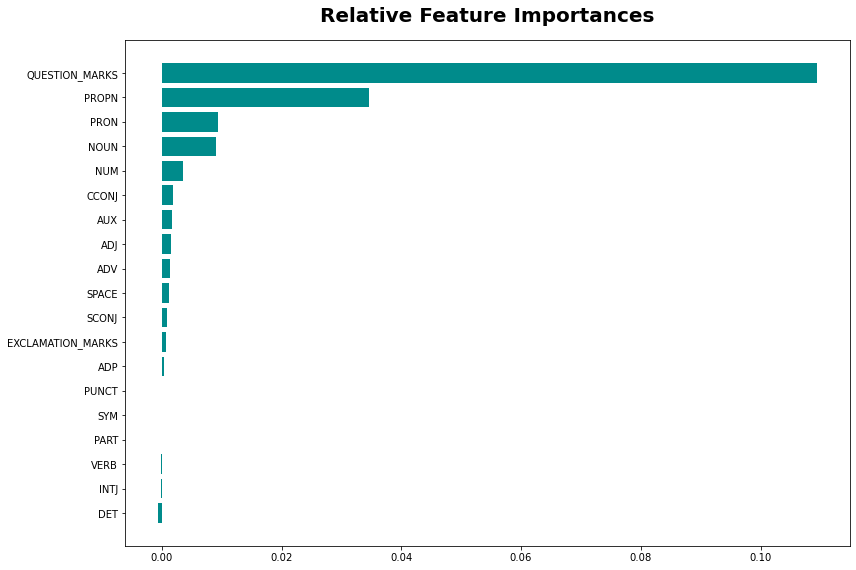

In [137]:
plt.figure(figsize=(12,8))

plt.barh(importance_df.index, importance_df[0], color='darkcyan')

plt.title('Relative Feature Importances', fontsize = 20, y=1.025,
          fontweight='bold')

plt.tight_layout()

plt.savefig('../Pictures/relative_feature_importances');


**Interpretation:** This graph helps to visualize the relative feature importances. Question marks outclass all other features by far.

In [201]:
cnsprcy_w_qmarks = df.loc[(df.is_conspiracy == 1) &
                         (df.question_marks != 0)].shape[0]

total_cnsprcy = df.loc[df.is_conspiracy == 1].shape[0]

round(cnsprcy_w_qmarks/total_cnsprcy, 3)

0.595

**Interpretation:** 59.5% of conspiracy posts contained question marks.

In [202]:
normal_w_qmarks = df.loc[(df.is_conspiracy == 0) &
                         (df.question_marks != 0)].shape[0]

total_normal = df.loc[df.is_conspiracy == 1].shape[0]

round(normal_w_qmarks/total_cnsprcy, 3)

0.088

**Interpretation:** 8.8% percent of 'normal' posts contained question marks.

In [203]:
df.groupby('is_conspiracy').describe()['question_marks']

,count,mean,std,min,25%,50%,75%,max
is_conspiracy,,,,,,,,
0,8544.0,0.005932,0.035613,0.0,0.0,0.000000,0.000000,1.0
1,8274.0,0.056666,0.108348,0.0,0.0,0.016667,0.064516,1.0


**Interpretation:** More conspiracy posts use question marks and those that do tend to use them with higher frequency.

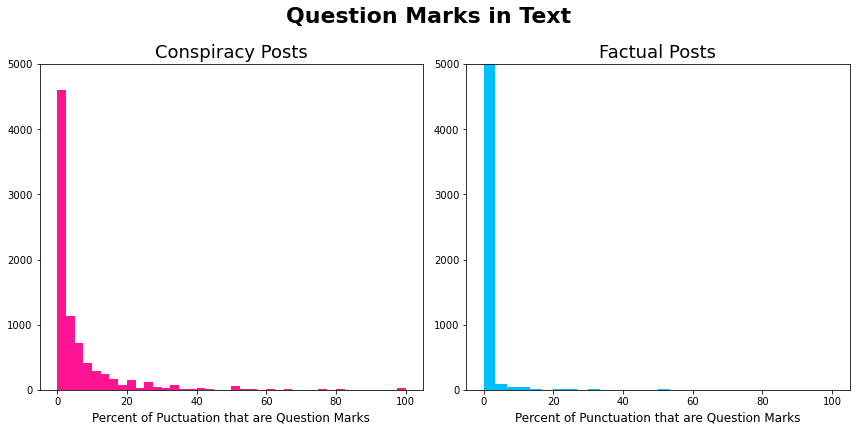

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(df.loc[df.is_conspiracy == 1]['QUESTION_MARKS']*100,
           bins=40, color='deeppink')
ax[0].set_ylim(0, 5000)
ax[0].set_title('Conspiracy Posts', fontsize=18)
ax[0].set_xlabel('Percent of Puctuation that are Question Marks', fontsize=12)


ax[1].hist(df.loc[df.is_conspiracy == 0]['QUESTION_MARKS']*100,
           bins=30, color='deepskyblue')
ax[1].set_ylim(0, 5000)
ax[1].set_title('Factual Posts', fontsize=18)
ax[1].set_xlabel('Percent of Punctuation that are Question Marks', fontsize=12)


fig.suptitle('Question Marks in Text',
             fontsize=22, fontweight='bold', y=0.99)
fig.tight_layout()

fig.savefig('../Pictures/question_marks_in_text');

**Interpretation:** Far more conspiracy posts use question marks than normal posts. My hypothesis is that conspiracy posts tend to use open ended questions to draw readers in before offering unsubstantiated explanations. Normal posts explaining a concept tend to address a singular topic and don't need to rely on open ended questions to guide a reader around.

In [198]:
cnsprcy_w_propn = df.loc[(df.is_conspiracy == 1) & (df.PROPN != 0)].shape[0]

total_cnsprcy = df.loc[df.is_conspiracy == 1].shape[0]

round(cnsprcy_w_propn/total_cnsprcy, 3)

0.818

**Interpretation:** 81.8 percent of conspiracy posts use proper nouns.

In [199]:
normal_w_propn = df.loc[(df.is_conspiracy == 0) & (df.PROPN != 0)].shape[0]

total_normal = df.loc[df.is_conspiracy == 0].shape[0]

round(normal_w_propn/total_normal, 3)

0.453

**Interpretation:** 45.3 percent of 'normal' posts use proper nouns

In [73]:
df.groupby('is_conspiracy').describe()['PROPN']

,count,mean,std,min,25%,50%,75%,max
is_conspiracy,,,,,,,,
0,8544.0,0.015677,0.024003,0.0,0.000000,0.000000,0.022727,0.387097
1,8274.0,0.029998,0.037906,0.0,0.005291,0.018182,0.041757,0.588957


**Interpretation:** More conspiracy posts use proper nouns and those that do tend to use them with higher frequency.

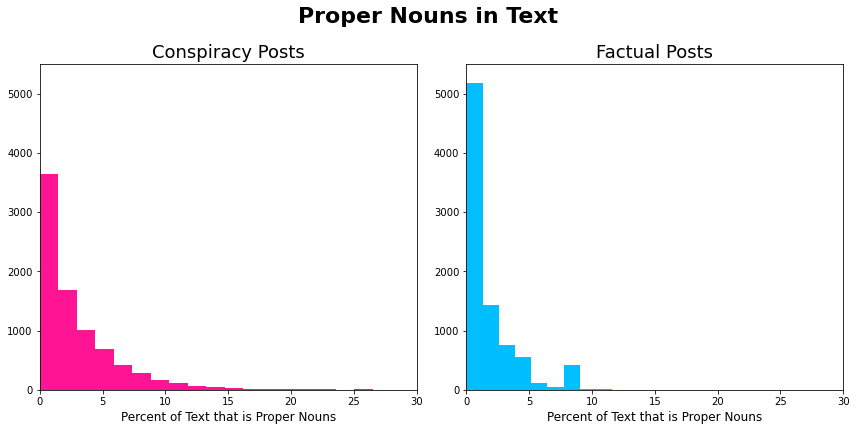

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(df.loc[df.is_conspiracy == 1]['PROPN']*100,
           bins=40, color='deeppink')
ax[0].set_ylim(0, 5500)
ax[0].set_xlim(0, 30)
ax[0].set_title('Conspiracy Posts', fontsize=18)
ax[0].set_xlabel('Percent of Text that is Proper Nouns', fontsize=12)


ax[1].hist(df.loc[df.is_conspiracy == 0]['PROPN']*100,
           bins=30, color='deepskyblue')
ax[1].set_ylim(0, 5500)
ax[1].set_xlim(0, 30)
ax[1].set_title('Factual Posts', fontsize=18)
ax[1].set_xlabel('Percent of Text that is Proper Nouns', fontsize=12)


fig.suptitle('Proper Nouns in Text',
             fontsize=22, fontweight='bold', y=0.99)
fig.tight_layout()

fig.savefig('../Pictures/proper_nouns_in_text');

a 'pos' appears in --% of cst posts vs --% in eli5 posts

**Interpretation:** More conspiracy posts use proper nouns and those that do use them with a higher frequency. My hypothesis is that conspiracy posts tend to make accusations about specific people they believe to be involved in the conspiracy they are describing. What is interesting to me is that while both distributions have positive skew the conspiracy posts have a much cleaner distribution.

In [81]:
df.groupby('is_conspiracy').describe()['NOUN']

,count,mean,std,min,25%,50%,75%,max
is_conspiracy,,,,,,,,
0,8544.0,0.192179,0.043306,0.0,0.163265,0.193182,0.222222,0.500000
1,8274.0,0.165888,0.037829,0.0,0.142857,0.164849,0.188406,0.454545


**Interpretation:** Normal posts tend to use more nouns than conspiracy posts although the difference is not as pronounced as with question marks and proper nouns.

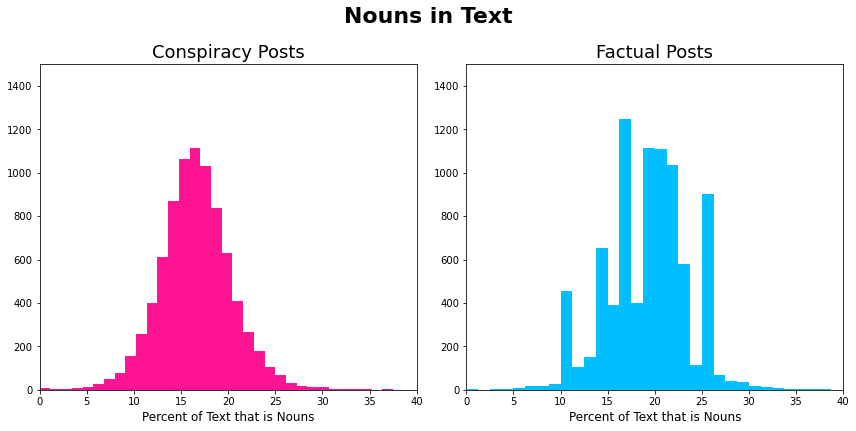

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(df.loc[df.is_conspiracy == 1]['NOUN']*100,
           bins=40, color='deeppink')
ax[0].set_ylim(0, 1500)
ax[0].set_xlim(0, 40)
ax[0].set_title('Conspiracy Posts', fontsize=18)
ax[0].set_xlabel('Percent of Text that is Nouns', fontsize=12)



ax[1].hist(df.loc[df.is_conspiracy == 0]['NOUN']*100,
           bins=40, color='deepskyblue')
ax[1].set_ylim(0, 1500)
ax[1].set_xlim(0, 40)
ax[1].set_title('Factual Posts', fontsize=18)
ax[1].set_xlabel('Percent of Text that is Nouns', fontsize=12)


fig.suptitle('Nouns in Text',
             fontsize=22, fontweight='bold', y=0.99)
fig.tight_layout()

fig.savefig('../Pictures/nouns_in_text');

**Interpretation:** The distribution of noun frequency is much more normal in conspiracy posts. I am not sure what to make of this. It's possible that the conspiracy posts have less unique users and that the normal distribution is a reflection of fewer writing styles. As a next step I would like to look into the number of unique posters per class.